In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# load the sg_object
with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [3]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [4]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [5]:
merged_gdf = sg_obj.gdf

In [6]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])

obs_cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes'] + cols_to_keep 

adata_genes.obs = df[obs_cols]

adata_genes.obs.index = [str(x) for x in adata_genes.obs.index]

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_72456/749676134.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [22]:
sg_obj.gdf

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
0,"POLYGON ((23727.000 1097.000, 23741.000 1098.0...","POLYGON ((23723.193 1087.753, 23706.193 1094.7...",POINT (23747.880 1155.889),23747.879606,1155.889230,12083.909039,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0
1,"POLYGON ((19439.000 1568.000, 19452.000 1569.0...","POLYGON ((19435.376 1558.680, 19417.376 1565.6...",POINT (19439.587 1590.119),19439.586687,1590.118851,3910.173214,10,10,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,"['bc_013', 'bc_060']",2
2,"POLYGON ((20345.000 1807.000, 20355.000 1818.0...","POLYGON ((20339.700 1798.520, 20333.649 1802.3...",POINT (20308.018 1845.079),20308.017937,1845.078634,6478.832120,100,100,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0
3,"POLYGON ((10876.000 2957.000, 10910.000 2999.0...","POLYGON ((10866.161 2955.211, 10864.921 2962.0...",POINT (10900.868 3028.338),10900.868011,3028.338325,11563.956381,1000,1000,5.0,0.0,...,0.0,0.0,0.0,0.0,454.0,bc_068-bc_086,"['bc_068', 'bc_086']",2.0,"['bc_068', 'bc_086']",2
4,"POLYGON ((34221.000 9631.000, 34230.000 9631.0...","POLYGON ((34216.771 9621.938, 34201.771 9628.9...",POINT (34222.068 9672.302),34222.068445,9672.302458,8075.173801,10000,10000,0.0,0.0,...,0.0,2.0,0.0,0.0,615.0,bc_004-bc_033,"['bc_004', 'bc_033']",2.0,"['bc_004', 'bc_033']",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67197,"POLYGON ((24154.000 9628.000, 24163.000 9628.0...","POLYGON ((24146.000 9622.000, 24140.000 9630.0...",POINT (24164.804 9654.365),24164.804188,9654.364679,2947.987326,9995,9995,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0
67198,"POLYGON ((5129.000 9629.000, 5144.000 9639.000...","POLYGON ((5121.929 9621.929, 5120.807 9623.051...",POINT (5137.538 9667.617),5137.538337,9667.616848,5874.912824,9996,9996,2.0,0.0,...,0.0,0.0,0.0,0.0,2722.0,bc_005-bc_030,"['bc_005', 'bc_030']",2.0,"['bc_005', 'bc_030']",2
67199,"POLYGON ((10140.000 9629.000, 10161.000 9631.0...","POLYGON ((10135.862 9619.896, 10124.862 9624.8...",POINT (10145.028 9672.194),10145.027695,9672.194417,7313.562537,9997,9997,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0
67200,"POLYGON ((13878.000 9629.000, 13901.000 9632.0...","POLYGON ((13871.753 9621.191, 13866.753 9625.1...",POINT (13913.353 9668.934),13913.352589,9668.934064,8293.379014,9998,9998,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0


In [24]:
adata_genes.obs

,cell_id,n_called_barcodes,barcode_names,called_barcodes,object_id,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
0,1,0,NaN,[],1,NaN,NaN,NaN,NaN
1,2,0,NaN,[],2,NaN,NaN,NaN,NaN
2,3,1,bc_060,['bc_060'],3,NaN,NaN,NaN,NaN
3,4,0,NaN,[],4,NaN,NaN,NaN,NaN
4,7,0,NaN,[],7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
67197,67193,0,NaN,[],67193,NaN,NaN,NaN,NaN
67198,67199,0,NaN,[],67199,NaN,NaN,NaN,NaN
67199,67200,0,NaN,[],67200,NaN,NaN,NaN,NaN
67200,67201,0,NaN,[],67201,NaN,NaN,NaN,NaN


Metrics based on filtering by 3 barcodes per cluster
Average cells per cluster 11.11659513590844
Number of clusters 1398
Metrics based on additionally filtering by 10 cells per cluster
Average cells per cluster 70.83707865168539
Number of clusters 178


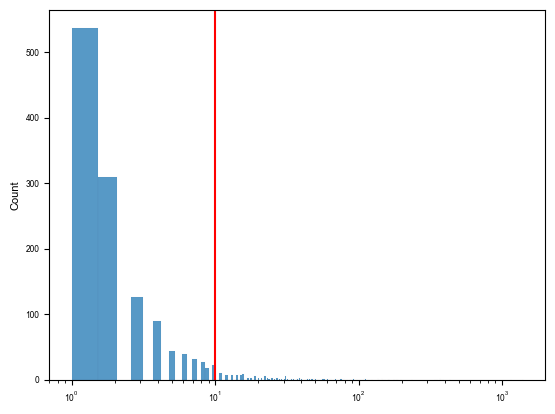

In [7]:
n_bcs_per_cluster_cutoff = 3
# n_cells_per_cluster_cutoff = 5
n_cells_per_cluster_cutoff = 10

# using the clustering to call clones
confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)

print(f'Metrics based on filtering by {n_bcs_per_cluster_cutoff} barcodes per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))

sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')
plt.xscale('log')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# sns.histplot(cluster_sizes)

print(f'Metrics based on additionally filtering by {n_cells_per_cluster_cutoff} cells per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))


In [8]:
np.unique(confident_clusters.obs['bc_cluster'].values)

array([   8.,   10.,   15.,   16.,   17.,   20.,   21.,   28.,   31.,
         35.,   41.,   42.,   47.,   49.,   51.,   53.,   62.,   71.,
         72.,   78.,   79.,   83.,   92.,   93.,   98.,  102.,  106.,
        109.,  112.,  121.,  138.,  146.,  157.,  165.,  167.,  170.,
        173.,  175.,  177.,  189.,  195.,  196.,  201.,  203.,  204.,
        207.,  214.,  218.,  220.,  222.,  225.,  228.,  233.,  237.,
        238.,  247.,  253.,  259.,  263.,  266.,  268.,  270.,  274.,
        284.,  288.,  299.,  308.,  309.,  318.,  319.,  323.,  332.,
        334.,  338.,  339.,  342.,  345.,  346.,  349.,  369.,  371.,
        372.,  374.,  384.,  391.,  394.,  397.,  400.,  404.,  406.,
        407.,  411.,  415.,  420.,  431.,  465.,  472.,  475.,  478.,
        490.,  511.,  514.,  527.,  537.,  539.,  548.,  553.,  557.,
        564.,  574.,  614.,  622.,  624.,  630.,  638.,  644.,  651.,
        652.,  657.,  672.,  680.,  681.,  691.,  720.,  722.,  726.,
        739.,  741.,

In [9]:
confident_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(confident_clusters.obs['bc_cluster'].values)]

In [10]:
confident_clusters_gdf

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
6,"POLYGON ((33928.000 9633.000, 33942.000 9635.0...","POLYGON ((33924.838 9623.513, 33915.838 9626.5...",POINT (33945.759 9675.416),33945.759162,9675.415681,8488.228745,10002,10002,0.0,0.0,...,0.0,9.0,0.0,0.0,845.0,bc_002-bc_004-bc_094,"['bc_002', 'bc_004', 'bc_094']",3.0,"['bc_002', 'bc_004', 'bc_094']",3
11,"POLYGON ((35965.000 9635.000, 35993.000 9637.0...","POLYGON ((35888.038 9755.805, 35889.191 9757.2...",POINT (35971.499 9701.483),35971.498673,9701.483157,18641.260537,10007,10007,2.0,0.0,...,0.0,0.0,0.0,0.0,548.0,bc_009-bc_014-bc_021,"['bc_009', 'bc_014', 'bc_021']",3.0,"['bc_009', 'bc_014', 'bc_019', 'bc_021']",4
14,"POLYGON ((12996.000 2958.000, 13010.000 2959.0...","POLYGON ((12979.064 3029.186, 12979.333 3029.4...",POINT (13001.707 2992.839),13001.706631,2992.839302,6153.822805,1001,1001,2.0,0.0,...,0.0,0.0,0.0,0.0,537.0,bc_001-bc_005-bc_025-bc_030,"['bc_001', 'bc_005', 'bc_025', 'bc_030']",4.0,"['bc_001', 'bc_025', 'bc_030']",3
18,"POLYGON ((19185.000 9637.000, 19201.000 9638.0...","POLYGON ((19181.390 9627.674, 19150.390 9639.6...",POINT (19188.053 9702.727),19188.053031,9702.727225,14807.975005,10013,10013,3.0,0.0,...,0.0,0.0,16.0,0.0,1190.0,bc_003-bc_076-bc_095,"['bc_003', 'bc_076', 'bc_095']",3.0,"['bc_003', 'bc_076', 'bc_095']",3
20,"POLYGON ((30631.000 9638.000, 30646.000 9640.0...","POLYGON ((30558.529 9732.873, 30562.700 9735.4...",POINT (30615.295 9688.707),30615.294706,9688.706524,11836.997397,10015,10015,0.0,0.0,...,0.0,0.0,0.0,0.0,138.0,bc_025-bc_039-bc_047-bc_058-bc_059-bc_076-bc_079,"['bc_025', 'bc_039', 'bc_047', 'bc_058', 'bc_0...",7.0,"['bc_025', 'bc_040', 'bc_047', 'bc_059', 'bc_0...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67176,"POLYGON ((19349.000 9618.000, 19360.000 9618.0...","POLYGON ((19348.445 9608.015, 19330.445 9609.0...",POINT (19329.817 9668.821),19329.817473,9668.821226,12284.464291,9976,9976,0.0,0.0,...,0.0,0.0,13.0,0.0,1190.0,bc_003-bc_076-bc_095,"['bc_003', 'bc_076', 'bc_095']",3.0,"['bc_003', 'bc_013', 'bc_076', 'bc_095']",4
67180,"POLYGON ((15698.000 2956.000, 15711.000 2956.0...","POLYGON ((15694.061 2946.809, 15680.061 2952.8...",POINT (15702.937 2988.794),15702.936864,2988.793734,5499.612463,998,998,1.0,0.0,...,0.0,0.0,0.0,0.0,2386.0,bc_025-bc_060-bc_062-bc_066,"['bc_025', 'bc_060', 'bc_062', 'bc_066']",4.0,"['bc_025', 'bc_060', 'bc_062', 'bc_066']",4
67187,"POLYGON ((30315.000 9623.000, 30332.000 9623.0...","POLYGON ((30288.075 9719.483, 30288.338 9719.9...",POINT (30351.533 9684.110),30351.533431,9684.109860,18563.854953,9986,9986,1.0,0.0,...,0.0,0.0,0.0,0.0,138.0,bc_025-bc_039-bc_047-bc_058-bc_059-bc_076-bc_079,"['bc_025', 'bc_039', 'bc_047', 'bc_058', 'bc_0...",7.0,"['bc_025', 'bc_039', 'bc_047', 'bc_058', 'bc_0...",8
67189,"POLYGON ((36956.000 9625.000, 36976.000 9626.0...","POLYGON ((36941.576 9622.135, 36941.294 9622.0...",POINT (36965.342 9653.127),36965.342480,9653.126698,5465.866622,9988,9988,2.0,0.0,...,0.0,0.0,0.0,0.0,548.0,bc_009-bc_014-bc_021,"['bc_009', 'bc_014', 'bc_021']",3.0,"['bc_009', 'bc_014']",2


In [11]:
### We can look at which clusters have the highest SFRP1 expression. Cluster 31 has the hightest.

confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

bc_cluster
31.0      3.379310
490.0     1.454545
41.0      0.692308
1136.0    0.571429
391.0     0.557377
253.0     0.529412
51.0      0.500000
415.0     0.479452
909.0     0.454545
1298.0    0.444444
Name: SFRP1, dtype: float64

In [12]:
## When we plotted Cluster 31, we noticed there were many neighboring cells that also expressed SFRP1. 
## We further manually annotated the cells in the neighborhood to ensure cells were correctly assigned to the cluster.

manual_annotation = pd.read_csv('../extractedData/in_vivo/cluster 31 manual annotation - manual_annotation_radius_large.csv')

manual_annotation= manual_annotation[manual_annotation['object_id'].notnull()]


In [13]:
manual_cluster = manual_annotation[((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE','TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['TRUE']))) |

                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE','TRUE']))) | 
                   
                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE']))) 

                   ] 
                   

In [14]:
sg_obj.gdf

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
0,"POLYGON ((23727.000 1097.000, 23741.000 1098.0...","POLYGON ((23723.193 1087.753, 23706.193 1094.7...",POINT (23747.880 1155.889),23747.879606,1155.889230,12083.909039,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0
1,"POLYGON ((19439.000 1568.000, 19452.000 1569.0...","POLYGON ((19435.376 1558.680, 19417.376 1565.6...",POINT (19439.587 1590.119),19439.586687,1590.118851,3910.173214,10,10,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,"['bc_013', 'bc_060']",2
2,"POLYGON ((20345.000 1807.000, 20355.000 1818.0...","POLYGON ((20339.700 1798.520, 20333.649 1802.3...",POINT (20308.018 1845.079),20308.017937,1845.078634,6478.832120,100,100,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0
3,"POLYGON ((10876.000 2957.000, 10910.000 2999.0...","POLYGON ((10866.161 2955.211, 10864.921 2962.0...",POINT (10900.868 3028.338),10900.868011,3028.338325,11563.956381,1000,1000,5.0,0.0,...,0.0,0.0,0.0,0.0,454.0,bc_068-bc_086,"['bc_068', 'bc_086']",2.0,"['bc_068', 'bc_086']",2
4,"POLYGON ((34221.000 9631.000, 34230.000 9631.0...","POLYGON ((34216.771 9621.938, 34201.771 9628.9...",POINT (34222.068 9672.302),34222.068445,9672.302458,8075.173801,10000,10000,0.0,0.0,...,0.0,2.0,0.0,0.0,615.0,bc_004-bc_033,"['bc_004', 'bc_033']",2.0,"['bc_004', 'bc_033']",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67197,"POLYGON ((24154.000 9628.000, 24163.000 9628.0...","POLYGON ((24146.000 9622.000, 24140.000 9630.0...",POINT (24164.804 9654.365),24164.804188,9654.364679,2947.987326,9995,9995,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0
67198,"POLYGON ((5129.000 9629.000, 5144.000 9639.000...","POLYGON ((5121.929 9621.929, 5120.807 9623.051...",POINT (5137.538 9667.617),5137.538337,9667.616848,5874.912824,9996,9996,2.0,0.0,...,0.0,0.0,0.0,0.0,2722.0,bc_005-bc_030,"['bc_005', 'bc_030']",2.0,"['bc_005', 'bc_030']",2
67199,"POLYGON ((10140.000 9629.000, 10161.000 9631.0...","POLYGON ((10135.862 9619.896, 10124.862 9624.8...",POINT (10145.028 9672.194),10145.027695,9672.194417,7313.562537,9997,9997,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0
67200,"POLYGON ((13878.000 9629.000, 13901.000 9632.0...","POLYGON ((13871.753 9621.191, 13866.753 9625.1...",POINT (13913.353 9668.934),13913.352589,9668.934064,8293.379014,9998,9998,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0


In [15]:
sg_obj.assigned_points_gdf

,name,refid,x,y,geometry,index_right,object_id,nucleus,distance_to_edge
3055875,CDK1,ENSG00000170312,50998,31118,POINT (50998.000 31118.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",123.685566
11908488,CCND1,ENSG00000110092,51009,31126,POINT (51009.000 31126.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",115.551054
11908492,CCND1,ENSG00000110092,50996,31167,POINT (50996.000 31167.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",115.115687
16545015,COL5A2,ENSG00000204262,51006,31150,POINT (51006.000 31150.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",113.741371
13013973,SPARC,ENSG00000113140,50997,31169,POINT (50997.000 31169.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",113.174236
...,...,...,...,...,...,...,...,...,...
16584996,ENSMUSG00000071361,ENSMUSG00000071361,9197,48023,POINT (9197.000 48023.000),NaN,NaN,None,NaN
16584997,ENSMUSG00000071361,ENSMUSG00000071361,9245,47972,POINT (9245.000 47972.000),NaN,NaN,None,NaN
16584998,ENSMUSG00000071361,ENSMUSG00000071361,10479,47915,POINT (10479.000 47915.000),NaN,NaN,None,NaN
16584999,ENSMUSG00000071361,ENSMUSG00000071361,42879,47872,POINT (42879.000 47872.000),NaN,NaN,None,NaN


In [16]:
list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

['28140',
 '28279',
 '28729',
 '30006',
 '30256',
 '30446',
 '30561',
 '30575',
 '30762',
 '30823',
 '30807',
 '30980',
 '31084',
 '31076',
 '31476',
 '31412',
 '31595',
 '31648',
 '31749',
 '31632',
 '31665',
 '31809',
 '31816',
 '32209',
 '32300',
 '32342',
 '32399',
 '32452',
 '32439',
 '32493',
 '32534',
 '32536',
 '32578',
 '32664',
 '32806',
 '32852',
 '32881',
 '32762',
 '32840',
 '32846',
 '32817',
 '33102',
 '33160',
 '33206',
 '33204',
 '33191',
 '33256',
 '33239',
 '33441',
 '33406',
 '33482',
 '33484',
 '33435',
 '33565',
 '33547',
 '33549',
 '33515',
 '33599',
 '33669',
 '33640',
 '33642',
 '33629',
 '33726',
 '33654',
 '33780',
 '33911',
 '33871',
 '33840',
 '33966',
 '33970',
 '33958',
 '34059',
 '33990',
 '34184',
 '34203',
 '34772',
 '34872',
 '35566',
 '36023']

In [17]:
list(adata_genes[adata_genes.obs['bc_cluster'].isin([31])].obs['cell_id'].values)

['28140',
 '28279',
 '28729',
 '30256',
 '30446',
 '30561',
 '30762',
 '30823',
 '30807',
 '31023',
 '31084',
 '31076',
 '31476',
 '31595',
 '31648',
 '31749',
 '31632',
 '31665',
 '31816',
 '31860',
 '32300',
 '32342',
 '32452',
 '32534',
 '32536',
 '32578',
 '32852',
 '32881',
 '32762',
 '32817',
 '32873',
 '32960',
 '33102',
 '33160',
 '33206',
 '33174',
 '33204',
 '33256',
 '33239',
 '33406',
 '33482',
 '33565',
 '33547',
 '33515',
 '33599',
 '33669',
 '33640',
 '33642',
 '33629',
 '33780',
 '33911',
 '33871',
 '33990',
 '34141',
 '34203',
 '34375',
 '34772',
 '36023']

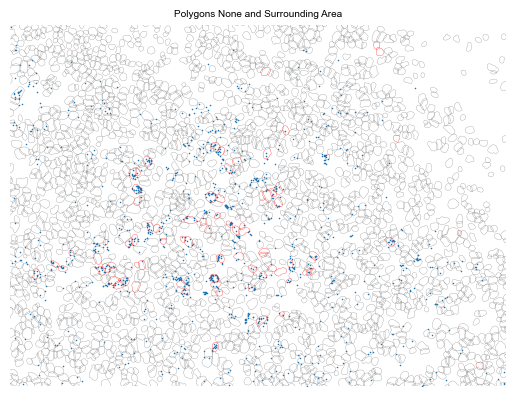

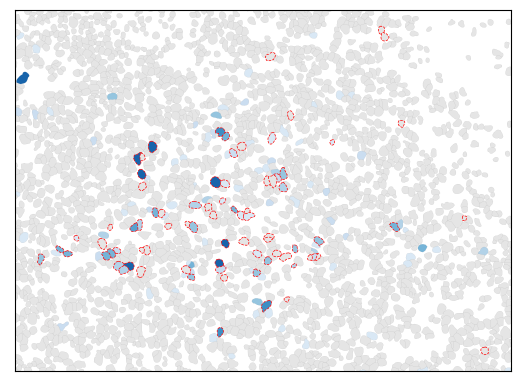

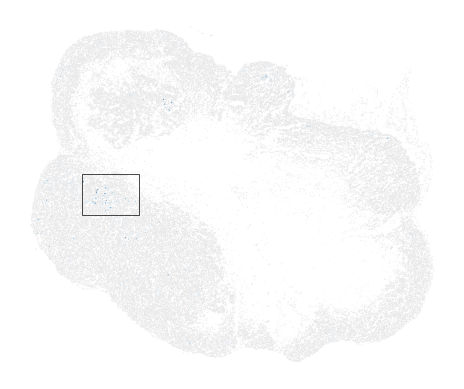

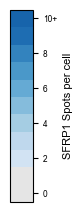

In [21]:
gene_of_interest = 'SFRP1'
cluster_of_interest = 31
# get the cells associated with the manual cluster
cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

# cluster_of_interest = [490]
# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster'].isin([cluster_of_interest])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2) 
cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=1,id_field='cell_id')

fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 2
vmax = 10

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

bbox = box(xmin,ymin,xmax,ymax)
other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

cmap = matplotlib.cm.get_cmap('Blues').copy()
cmap = cmap(np.linspace(0.15, 0.8, 256))

cmap = matplotlib.colors.ListedColormap(cmap)
cmap.set_under('#e5e5e5') # set low values to gray

merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

# Add the patch to the Axes
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

ax.set_xticks([])
ax.set_yticks([])
# ax.set_facecolor('#F5F5F5')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_zoom_grayed.pdf',bbox_inches='tight')


### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
fig,ax = plt.subplots()

merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.0)

# rectangle where magnification is
rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

ax.set_facecolor('#F5F5F5')
plt.axis('off')
plt.gca().invert_yaxis()

plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full_grayed.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full_grayed.png',dpi=500,bbox_inches='tight',transparent=True)


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(0.3,2.5))
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])

plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_colorbar_grayed.pdf',bbox_inches='tight',transparent=True)



Entire Tumor
Mean SFRP1 epxression: 0.10002678491711556
Fraction of cells with SFRP1 > 1: 0.015088836641766613
number of cells total: 67202
number of cells with SFRP1 > 1: 1014
Neighbors
Mean SFRP1 expression: 0.17717842323651453
Fraction of cells with SFRP1 > 1: 0.033609958506224065
number of cells total: 2410
number of cells with SFRP1 > 1: 81
clone 31
Mean SFRP1 expression: 3.7468354430379747
Fraction of cells with SFRP1 > 1: 0.5822784810126582
number of cells total: 79
number of cells with SFRP1 > 1: 46


Text(0.5, 0, 'Proportion of cells in group (sorted)')

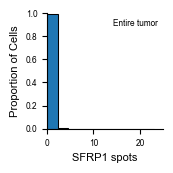

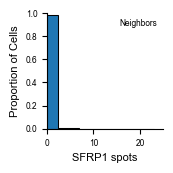

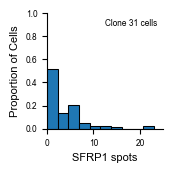

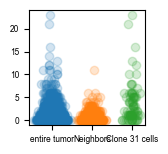

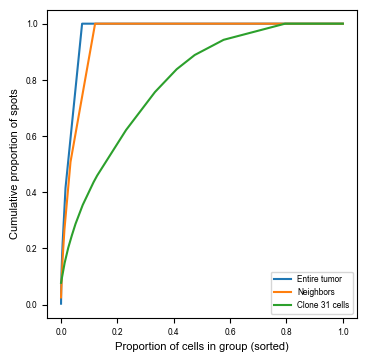

In [15]:
#### plot distributions of counts within the clone, compared to its neighborhood and the entire tumor 
# plt.subplots(figsize=(12,4),sharex=True,sharey=True)
# non_zero_cells = df[df['SFRP1']>1]
counts,bins = np.histogram(df['SFRP1'])

cluster_of_interest = 31

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# entire tumor
# ax = plt.subplot(1,3,3)
plt.text(s='Entire tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(df['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_full.pdf',bbox_inches='tight',transparent=True)

print('Entire Tumor')
print('Mean SFRP1 epxression:',df['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1)/len(df))
print('number of cells total:',len(df))
print('number of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_neighbors.pdf',bbox_inches='tight',transparent=True)

print('Neighbors')
print('Mean SFRP1 expression:',df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1)/len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells total:',len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# clone 31
# ax = plt.subplot(1,3,1)
plt.text(s='Clone 31 cells',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
sns.histplot(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_hists.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_clone31.pdf',bbox_inches='tight',transparent=True)

print('clone 31')
print('Mean SFRP1 expression:',df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1)/len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells total:',len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1))


fig,ax = plt.subplots(figsize=(1.5,1.5))

# entire tumor
ax.scatter([tools.jitter_point(0,0.1) for x in df['SFRP1']],
            df['SFRP1'],alpha=0.2)


# neighbors
neighbors = df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]
ax.scatter([tools.jitter_point(1,0.1) for x in neighbors['SFRP1']],
            neighbors['SFRP1'],alpha=0.2)

# clone 31
ax.scatter([tools.jitter_point(2,0.1) for x in df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']],
            df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],alpha=0.2)
# sns.histplot(,bins=bins,alpha=1.0,stat='proportion',ax=ax)

plt.xticks(range(3),['entire tumor','Neighbors','Clone 31 cells'])
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_jitter.pdf',bbox_inches='tight')

fig,ax = plt.subplots(figsize=(4,4))
plt.plot(np.linspace(0,1,len(df['SFRP1'])),
         np.cumsum(df['SFRP1'].sort_values(ascending=False).values)/np.sum(df['SFRP1']),
         label='Entire tumor')
plt.plot(np.linspace(0,1,len(neighbors['SFRP1'])),
         np.cumsum(neighbors['SFRP1'].sort_values(ascending=False).values)/np.sum(neighbors['SFRP1']),
         label='Neighbors')
plt.plot(np.linspace(0,1,len(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'])),
         np.cumsum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].sort_values(ascending=False).values)/np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']),
         label='Clone 31 cells')
plt.legend()

plt.ylabel('Cumulative proportion of spots')
plt.xlabel('Proportion of cells in group (sorted)')



In [16]:
# plot SFRP1 spots for the whole roi

# open spots file
spots_df = pd.read_csv(tools.roi_file_paths[roi_of_interest]["spots_file"])

<Figure size 640x480 with 0 Axes>

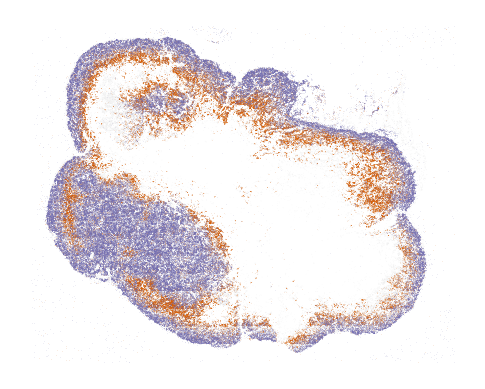

In [17]:
# plt.figure()
gene_of_interest = 'SFRP1'

gene_list = ['VEGFA',
             'MITF',
            #  'SPARC',
            'SFRP1',
                ]

gene_list = ['VEGFA',
             'MITF',
            #  'SPARC',
            # 'SFRP1',
                ]

gene_colors = {'VEGFA':'b',
               'MITF':'r',}

gene_colors = {
                # 'VEGFA':'#5e3c99',
               'VEGFA':'#d95f02',
               
            #    'MITF':'#e66101',
               'MITF':'#7570b3',
               
               }


plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)

for gene_of_interest in gene_list:

    # get the spots for the gene of interest
    spots_gene = spots_df[spots_df['name']==gene_of_interest]

    plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color=gene_colors[gene_of_interest])

plt.axis('off')
# plt.title(gene_of_interest)
plt.gca().invert_yaxis()

plt.savefig(f'../graphs/space_VEGFA_MITF_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/space_VEGFA_MITF_full.png',dpi=500,bbox_inches='tight',transparent=True)

    

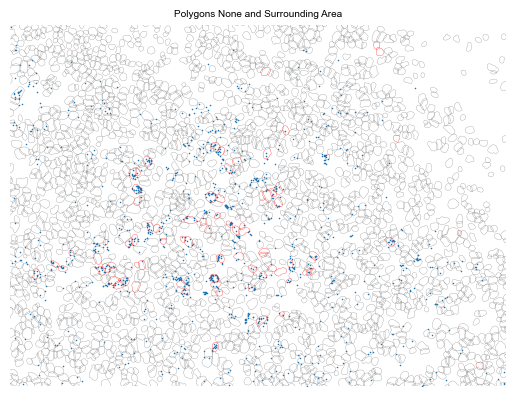

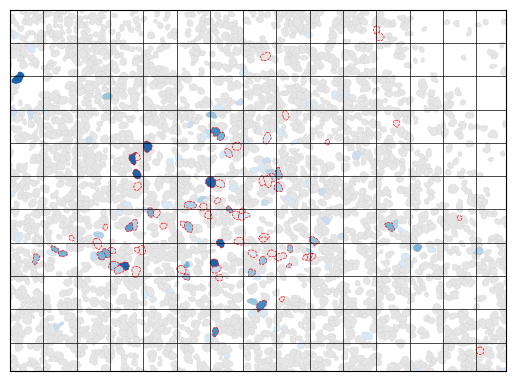

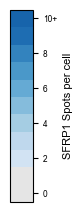

In [18]:
# comparision to grid-based spatial transcriptomics technologies

gene_of_interest = 'SFRP1'
cluster_of_interest = 31

# get the cells associated with the manual cluster
cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)
central_ix = int(len(cluster_cells)/2) 
cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=1,id_field='cell_id')

fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 2
vmax = 10

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

bbox = box(xmin,ymin,xmax,ymax)
other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

cmap = matplotlib.cm.get_cmap('Blues').copy()
cmap = cmap(np.linspace(0.15, 0.8, 256))

cmap = matplotlib.colors.ListedColormap(cmap)
cmap.set_under('#e5e5e5') # set low values to gray

merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

# visium HD has theoretical 2 micron grid size. This is roughly every 2000/107 = 18.7 pixels
# plt.gca().set_xticks([xmin+18.7*i for i in range(int((xmax-xmin)/18.7)+1)])
# plt.gca().set_yticks([ymin+18.7*i for i in range(int((ymax-ymin)/18.7)+1)])

# visium HD has 8 micron grid size as recommended resolution. This is roughly every 8000/107 =74.77 pixels
# plt.gca().set_xticks([xmin+74.77*i for i in range(int((xmax-xmin)/74.77)+1)])
# plt.gca().set_yticks([ymin+74.77*i for i in range(int((ymax-ymin)/74.77)+1)])

# visium has 55 micron grid size. This is roughly every 55000/107 = 514 pixels
plt.gca().set_xticks([xmin+514*i for i in range(int((xmax-xmin)/514)+1)])
plt.gca().set_yticks([ymin+514*i for i in range(int((ymax-ymin)/514)+1)])
plt.gca().tick_params(which='major', color='k',length=0)
plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

# plt.gca().tick_params()

ax.tick_params(axis='both', which='major', labelsize=5)
ax.tick_params(axis='both', which='minor', labelsize=2)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_zoom_grid.pdf',bbox_inches='tight')



### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(0.3,2.5))
# cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
#                             norm=norm,
#                             orientation='vertical')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])
# ax.set_yticks([x+0.5 for x in [0,2,4,6,8,10]],[0,2,4,6,8,10])

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_colorbar_grayed_grid.pdf',bbox_inches='tight',transparent=True)


# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')



In [19]:
gene_of_interest = 'SFRP1'
cluster_of_interest = 31

# get the cells associated with the manual cluster
cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)
central_ix = int(len(cluster_cells)/2) 
cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

In [20]:
region

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
22042,"POLYGON ((9717.000 22600.000, 9735.000 22600.0...","POLYGON ((9634.000 22672.019, 9633.716 22672.3...",POINT (9709.981 22691.239),9709.981075,22691.239367,22882.252109,29837,29837,8.0,0.0,...,0.0,0.0,0.0,0.0,20.0,bc_004-bc_041-bc_077,"['bc_004', 'bc_041', 'bc_077']",3.0,"['bc_001', 'bc_004', 'bc_031', 'bc_041', 'bc_0...",6
22071,"POLYGON ((9534.000 22614.000, 9554.000 22619.0...","POLYGON ((9530.286 22604.715, 9505.286 22614.7...",POINT (9522.313 22687.887),9522.313194,22687.886842,18887.967022,29863,29863,3.0,0.0,...,0.0,0.0,0.0,0.0,120.0,bc_022,['bc_022'],1.0,['bc_022'],1
22075,"POLYGON ((9803.000 22617.000, 9813.000 22617.0...","POLYGON ((9799.989 22607.464, 9781.922 22613.1...",POINT (9803.283 22680.617),9803.282576,22680.617043,13631.535890,29867,29867,1.0,0.0,...,0.0,0.0,0.0,0.0,404.0,bc_001-bc_024-bc_029-bc_031-bc_087,"['bc_001', 'bc_024', 'bc_029', 'bc_031', 'bc_0...",5.0,"['bc_001', 'bc_022', 'bc_024', 'bc_029', 'bc_0...",6
22098,"POLYGON ((10294.000 22627.000, 10307.000 22632...","POLYGON ((10285.679 22621.453, 10285.677 22621...",POINT (10301.614 22698.610),10301.614233,22698.610197,13338.203270,29888,29888,2.0,0.0,...,0.0,0.0,0.0,0.0,72.0,bc_001-bc_029-bc_031-bc_087,"['bc_001', 'bc_029', 'bc_031', 'bc_087']",4.0,"['bc_001', 'bc_029', 'bc_031', 'bc_066', 'bc_0...",5
22104,"POLYGON ((10597.000 22628.000, 10608.000 22632...","POLYGON ((10564.911 22726.037, 10567.152 22738...",POINT (10604.700 22697.795),10604.700122,22697.794656,10563.854325,29893,29893,0.0,0.0,...,1.0,0.0,0.0,0.0,1870.0,bc_060-bc_087,"['bc_060', 'bc_087']",2.0,"['bc_006', 'bc_048', 'bc_060', 'bc_066', 'bc_0...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28678,"POLYGON ((11727.000 26202.000, 11745.000 26202...","POLYGON ((11708.009 26277.187, 11708.050 26278...",POINT (11731.427 26236.393),11731.426838,26236.392676,5600.912270,35809,35809,4.0,0.0,...,0.0,0.0,0.0,0.0,352.0,bc_060,['bc_060'],1.0,"['bc_031', 'bc_060', 'bc_087']",3
28696,"POLYGON ((11394.000 26213.000, 11396.000 26217...","POLYGON ((11389.795 26203.927, 11348.795 26222...",POINT (11375.828 26283.604),11375.828172,26283.604256,15653.183784,35825,35825,2.0,0.0,...,0.0,0.0,0.0,0.0,1664.0,bc_001-bc_024-bc_031-bc_048-bc_060-bc_087,"['bc_001', 'bc_024', 'bc_031', 'bc_048', 'bc_0...",6.0,"['bc_001', 'bc_024', 'bc_031', 'bc_048', 'bc_0...",6
28699,"POLYGON ((9508.000 26214.000, 9509.000 26217.0...","POLYGON ((9499.176 26209.294, 9483.176 26239.2...",POINT (9490.126 26326.838),9490.125765,26326.837807,17228.114514,35828,35828,3.0,0.0,...,0.0,0.0,0.0,0.0,20.0,bc_004-bc_041-bc_077,"['bc_004', 'bc_041', 'bc_077']",3.0,"['bc_004', 'bc_041']",2
28700,"POLYGON ((10305.000 26214.000, 10316.000 26215...","POLYGON ((10301.672 26204.570, 10284.672 26210...",POINT (10327.154 26257.377),10327.154210,26257.376605,10103.251840,35829,35829,3.0,0.0,...,0.0,0.0,0.0,0.0,360.0,bc_024,['bc_024'],1.0,"['bc_024', 'bc_048', 'bc_087']",3


In [21]:
clusters,counts = np.unique(region['bc_cluster'],return_counts=True)

# get the clusters with at least 10 cells
clusters = clusters[counts>=10]
# drop na
clusters = clusters[~np.isnan(clusters)]

cluster_correlation = []

points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1']

bin_size = 514 # visium bin size
# bin_size = 74.77 # visiumHD bin size

n_x_bins = int((xmax-xmin)/bin_size)+1
n_y_bins = int((ymax-ymin)/bin_size)+1

H_gene, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(n_x_bins)],
                                                                   [ymin+bin_size*i for i in range(n_y_bins)]],
                                                                   range=[[xmin,xmin+bin_size*n_x_bins],[ymin,ymin+bin_size*n_x_bins]])
for c,cluster in enumerate(clusters):

    this_name = region[region['bc_cluster']==cluster]['bc_cluster_bc_names'].values[0]
    cluster_barcodes = this_name.split('-')

    points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name'].isin(cluster_barcodes)]

    H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(int((xmax-xmin)/bin_size)+1)],
                                                                   [ymin+bin_size*i for i in range(int((ymax-ymin)/bin_size)+1)]],
                                                                   range=[[xmin,xmax],[ymin,ymax]])
    
    print(cluster)
    print(scipy.stats.pearsonr(H_gene.flatten(),H.flatten()))

    cluster_correlation.append(scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[0])


# plt.savefig('../graphs/cluster_31_SFRP1_spots_visiumcomparision.pdf',bbox_inches='tight')
# plt.savefig('plots/figures/forpaper_cluster_31_SFRP1_spots_visiumHDcomparision.pdf',bbox_inches='tight')

20.0
PearsonRResult(statistic=0.2742843912152619, pvalue=0.001040250614946966)
31.0
PearsonRResult(statistic=0.8118829683474638, pvalue=4.641415937721726e-34)
72.0
PearsonRResult(statistic=-0.07803025460348703, pvalue=0.35946389746130447)
165.0
PearsonRResult(statistic=0.2587564710911205, pvalue=0.0020222229161292195)
196.0
PearsonRResult(statistic=0.31950221426542025, pvalue=0.00011915248357490022)
211.0
PearsonRResult(statistic=0.06969821047053303, pvalue=0.41319592497954005)
324.0
PearsonRResult(statistic=0.2345213729754362, pvalue=0.0052867347888511185)
360.0
PearsonRResult(statistic=0.17952865290898268, pvalue=0.033800559709837245)
539.0
PearsonRResult(statistic=0.2518635789741325, pvalue=0.002682824081235376)
648.0
PearsonRResult(statistic=0.2788738106428938, pvalue=0.0008482713384591332)
919.0
PearsonRResult(statistic=0.29915457669001005, pvalue=0.00033005068990201234)


In [22]:
clusters

array([ 20.,  31.,  72., 165., 196., 211., 324., 360., 539., 648., 919.])

31.0
PearsonRResult(statistic=0.8118829683474638, pvalue=4.641415937721726e-34)
196.0
PearsonRResult(statistic=0.31950221426542025, pvalue=0.00011915248357490022)
919.0
PearsonRResult(statistic=0.29915457669001005, pvalue=0.00033005068990201234)
648.0
PearsonRResult(statistic=0.2788738106428938, pvalue=0.0008482713384591332)
20.0
PearsonRResult(statistic=0.2742843912152619, pvalue=0.001040250614946966)
165.0
PearsonRResult(statistic=0.2587564710911205, pvalue=0.0020222229161292195)
539.0
PearsonRResult(statistic=0.2518635789741325, pvalue=0.002682824081235376)
324.0
PearsonRResult(statistic=0.2345213729754362, pvalue=0.0052867347888511185)
360.0
PearsonRResult(statistic=0.17952865290898268, pvalue=0.033800559709837245)


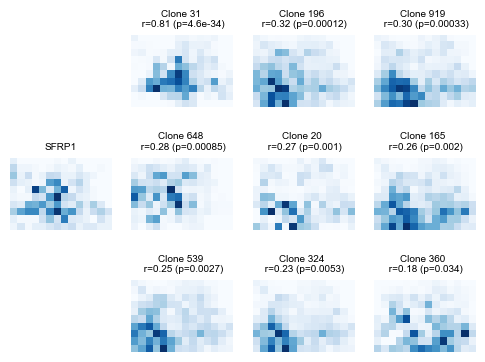

In [23]:
clusters,counts = np.unique(region['bc_cluster'],return_counts=True)

# get the clusters with at least 10 cells
clusters = clusters[counts>=10]
# drop na
clusters = clusters[~np.isnan(clusters)]

clusters = clusters[np.argsort(cluster_correlation)[::-1]]
correlations = np.sort(cluster_correlation)[::-1]

plt.figure(figsize=(4*1.5,3*1.5))
plt.subplot(3,4,5)
points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1']

bin_size = 514 # visium bin size
# bin_size = 74.77 # visiumHD bin size

n_x_bins = int((xmax-xmin)/bin_size)+1
n_y_bins = int((ymax-ymin)/bin_size)+1

H_gene, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(n_x_bins)],
                                                                   [ymin+bin_size*i for i in range(n_y_bins)]],
                                                                   range=[[xmin,xmin+bin_size*n_x_bins],[ymin,ymin+bin_size*n_x_bins]])

# Plot the 2D histogram
plt.imshow(H_gene.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Blues')
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
plt.gca().invert_yaxis()
plt.title('SFRP1')

# plt.gca().set_xticks(xedges)
# plt.gca().set_yticks(yedges)
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

# plt.xticks()
plt.axis('off')
# plt.show()

counter = 0

subplot_list = [2,3,4,6,7,8,10,11,12]

for c,cluster in enumerate(clusters):

    if correlations[c] < 0.15:
        continue
    
    c = counter

    this_name = region[region['bc_cluster']==cluster]['bc_cluster_bc_names'].values[0]
    cluster_barcodes = this_name.split('-')

    points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name'].isin(cluster_barcodes)]

    H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(int((xmax-xmin)/bin_size)+1)],
                                                                   [ymin+bin_size*i for i in range(int((ymax-ymin)/bin_size)+1)]],
                                                                   range=[[xmin,xmax],[ymin,ymax]])
    
    print(cluster)
    print(scipy.stats.pearsonr(H_gene.flatten(),H.flatten()))

    plt.subplot(3,4,subplot_list[c])

    # Plot the 2D histogram
    plt.imshow(H.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Blues')
    # plt.colorbar()
    # plt.gca().set_aspect('equal')
    # plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
    plt.gca().invert_yaxis()
    plt.title(f'Clone {int(cluster)} \n r={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[0]:.2f} (p={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[1]:.2g})')
    plt.axis('off')

    counter += 1

plt.savefig('../graphs/cluster_31_SFRP1_spots_visiumcomparision.pdf',bbox_inches='tight')
# plt.savefig('plots/figures/forpaper_cluster_31_SFRP1_spots_visiumHDcomparision.pdf',bbox_inches='tight')

In [24]:
confident_clusters_gdf.groupby(by='bc_cluster')['IFIT2'].mean().sort_values(ascending=False).head(10)

bc_cluster
756.0     0.593750
527.0     0.578947
722.0     0.500000
15.0      0.477157
490.0     0.454545
1303.0    0.322581
681.0     0.300000
266.0     0.291209
93.0      0.263158
72.0      0.261494
Name: IFIT2, dtype: float64

In [25]:
# confident_clusters_gdf.groupby(by='bc_cluster')['IFIT2']


confident_clusters_gdf[confident_clusters_gdf['IFIT2'] > 1].groupby(by='bc_cluster')['IFIT2'].count().sort_values(ascending=False).head(10)

bc_cluster
72.0      38
372.0     17
15.0       9
756.0      5
266.0      5
138.0      4
62.0       3
1303.0     3
2051.0     3
238.0      2
Name: IFIT2, dtype: int64

In [26]:
adata_genes.obs['bc_cluster']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
67197   NaN
67198   NaN
67199   NaN
67200   NaN
67201   NaN
Name: bc_cluster, Length: 67202, dtype: float64

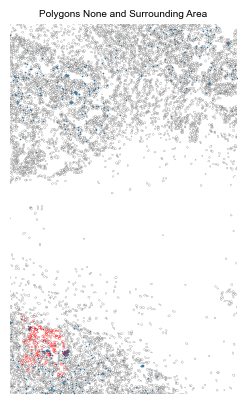

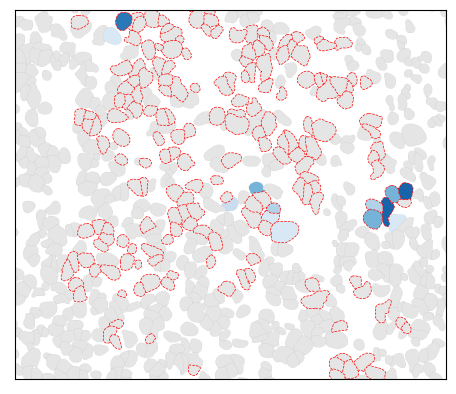

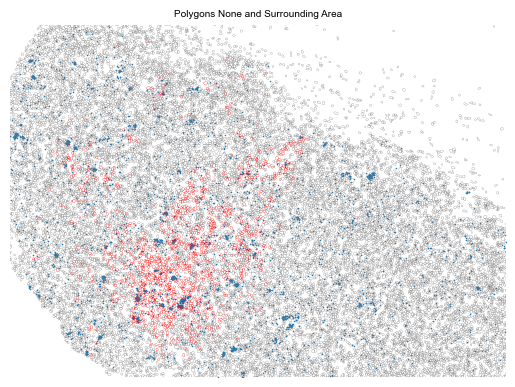

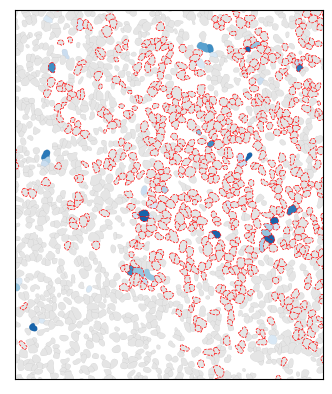

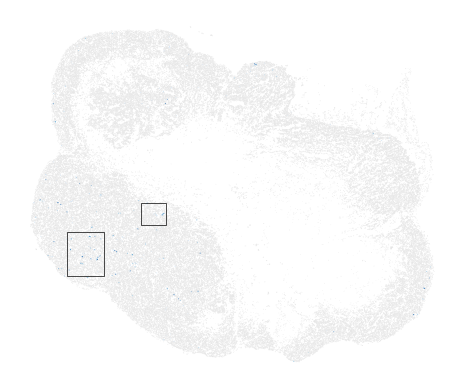

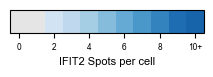

In [27]:
gene_of_interest = 'IFIT2'
clusters_of_interest = [15,72]
# clusters_of_interest = [72,372,15,756]

custom_lims = {15:[17000,20500,25000,28000],
               
               72:[7000,12000,29000,35000],}

cluster_boxes = {}

for cluster_of_interest in clusters_of_interest:

    # get the cells associated with the manual cluster
    cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster'].isin([cluster_of_interest])].obs['cell_id'].values)
    central_ix = int(len(cluster_cells)/2) 
    cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=-0.5,id_field='cell_id')

    fig,ax = plt.subplots()
    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=[gene_of_interest],central_polygon_ix=central_ix,
                                color_map={gene_of_interest:(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                                #    id_field='cell_id',
                                annotate=False,image_scale=0.1,
                                focal_outline_color='r',other_outline_color='gray',
                                interior_marker='.',single_mode=False,lw=0.2,
                                exterior_marker='.',marker_size=5,ax=ax)

    ymin,ymax = plt.ylim()
    xmin,xmax = plt.xlim()

    plt.axis('off')
    # plt.title()
    plt.gca().invert_yaxis()

    ### PLOT THE ZOOMED IN IMAGE     
    fig,ax = plt.subplots()

    vmin = 2
    vmax = 10

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    xmin = custom_lims[cluster_of_interest][0]
    xmax = custom_lims[cluster_of_interest][1]
    ymin = custom_lims[cluster_of_interest][2]
    ymax = custom_lims[cluster_of_interest][3]

    bbox = box(xmin,ymin,xmax,ymax)
    # bbox = box(custom_lims[cluster_of_interest][0],custom_lims[cluster_of_interest][2],custom_lims[cluster_of_interest][1],custom_lims[cluster_of_interest][3])
    other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

    merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

    cmap = matplotlib.cm.get_cmap('Blues').copy()
    cmap = cmap(np.linspace(0.15, 0.8, 256))

    cmap = matplotlib.colors.ListedColormap(cmap)
    cmap.set_under('#e5e5e5') # set low values to gray

    merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
    # this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

    merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

    # print(merged_gdf_focal.shape)
    merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

    # Add the patch to the Axes
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.gca().invert_yaxis()

    cluster_boxes[cluster_of_interest] = [xmin,xmax,ymin,ymax]

    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_facecolor('#F5F5F5')
    plt.savefig(f'../graphs/cluster_{cluster_of_interest}_{gene_of_interest}_zoom_grayed.pdf',bbox_inches='tight')


### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
fig,ax = plt.subplots()

merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.0)

rects = {}
for cluster,cluster_box in cluster_boxes.items():
    # rectangle where magnification is
    rects[cluster] = matplotlib.patches.Rectangle((cluster_box[0], cluster_box[2]), (cluster_box[1]-cluster_box[0]), 
                                        (cluster_box[3]-cluster_box[2]), linewidth=0.5, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rects[cluster])

ax.set_facecolor('#F5F5F5')
plt.axis('off')
plt.gca().invert_yaxis()

plt.savefig(f'../graphs/{gene_of_interest}_full_grayed.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/{gene_of_interest}_full_grayed.png',dpi=500,bbox_inches='tight',transparent=True)


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(2.5,0.3))
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='horizontal')
cb1.set_label(f'{gene_of_interest} Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])

plt.savefig(f'../graphs/{gene_of_interest}_colorbar_grayed.pdf',bbox_inches='tight',transparent=True)

